# Dynamic Aperture
*This notebook will soon be refactored into a single SciBmad function for general usage*

Thanks to SciBmad's support for both explicit Single Instruction, Multiple Data (SIMD) on the CPU and Single Instruction, Multiple Thread (SIMT) on the GPU, highly-parallelized and performant tracking simulations can be run on all types of architectures. Here we will do a dynamic aperture scan of the v6.3.1 Electron Storage Ring (ESR) of the Electron-Ion Collider (EIC).

In [76]:
using SciBmad, CairoMakie, DelimitedFiles

In [80]:
include("../lattices/esr-v6.3.1-tapered.jl");

In [81]:
# Turn on radiation damping, do 2nd order Yoshida for speed
foreach(t->t.tracking_method=SciBmad.Yoshida(order=2, radiation_damping_on=true), ring.line)

# Twiss:
t = twiss(ring)

# Tunes:
t.phi_1[end], t.phi_2[end], t.phi_3[end]

(48.08009187398919, 44.140163188396954, -0.04999949805244903)

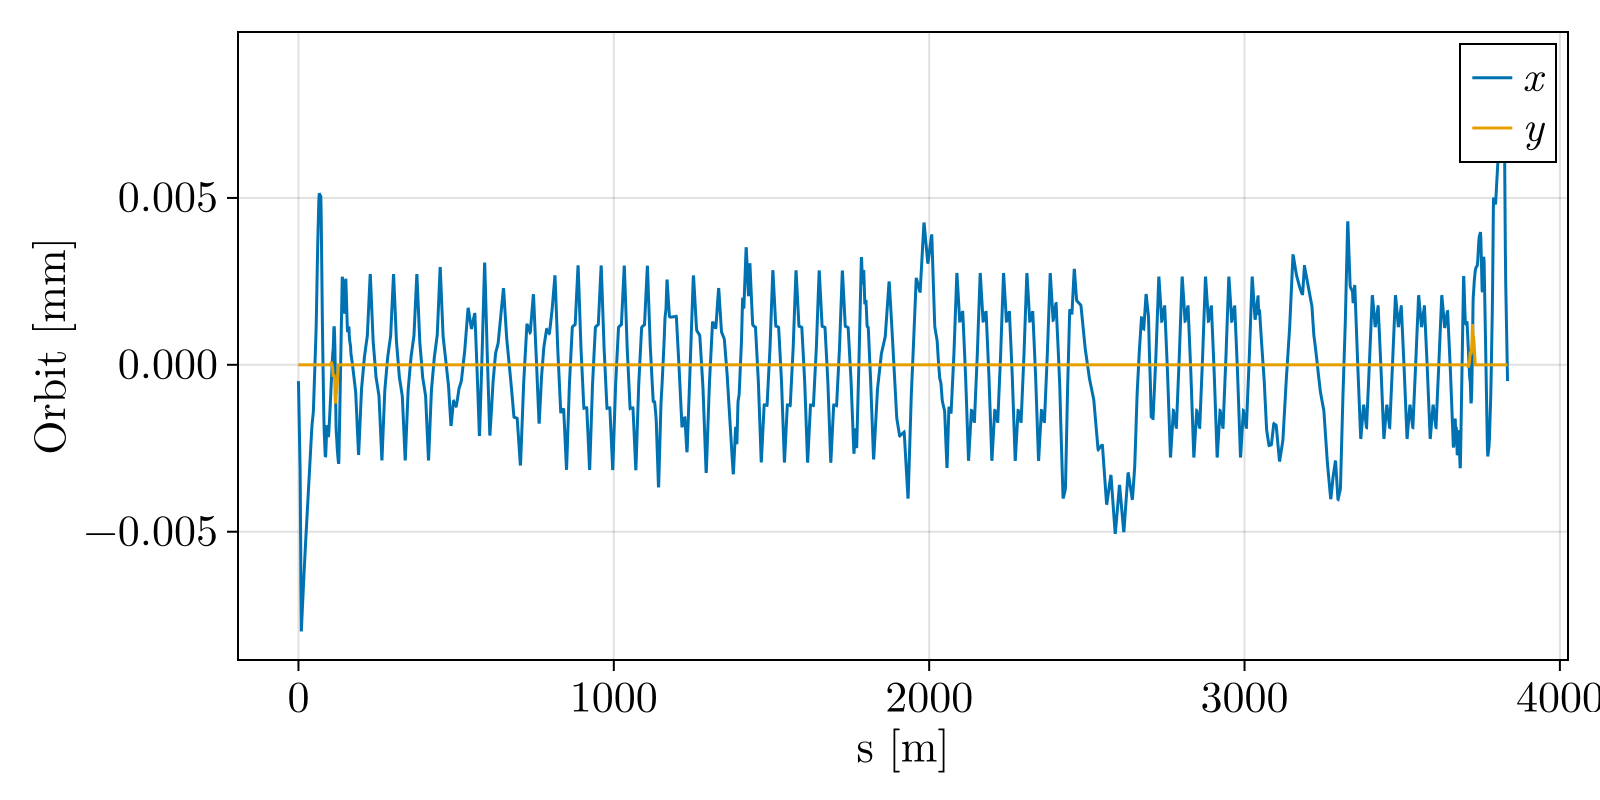

In [82]:
# Plot the orbit:
set_theme!(theme_latexfonts())

f = Figure(fontsize=22, size=(800,400));
ax = Axis(f[1, 1], xlabel="s [m]", ylabel="Orbit [mm]");
lines!(ax, t.s, t.orbit_x.*10^3, label=L"x"); 
lines!(ax, t.s, t.orbit_y.*10^3, label=L"y");
axislegend(position=:rt);
display(f);

In [83]:
# Now let's do DA scan. we will track a bunch and see what happens
# Using numbers from previous DA studies:
emit_a = 30e-9
emit_b = 15e-9       # Very conservative...
emit_c = 7.30474E-06 # From Bmad/PTC

7.30474e-6

In [84]:
# To compute sig_x, need to convert eigenemittances to moments
# Use de moivre:
td = twiss(ring; de_moivre=true);

In [85]:
# Now compute sigmas at first element (IP)
E = td.E[1]
sig_x = sqrt(E[1][1,1]*emit_a + E[2][1,1]*emit_b + E[3][1,1]*emit_c)
sig_y = sqrt(E[1][3,3]*emit_a + E[2][3,3]*emit_b + E[3][3,3]*emit_c)
sig_x, sig_y

(0.00013305649094121137, 2.9244009573070492e-5)

In [92]:
# Create polar grid distribution for various deltas
# Initialize matrix of particles:
n_r = 30
n_theta = 65
deltas = (0:0.1:1).*10^-2 # 0.1-1% delta
max_sig_x = 15
max_sig_y = 22

thetas = range(0, pi, length=n_theta)
rs = range(0, 1, length=n_r)[2:end]

N_particles = length(deltas)*(1+length(rs)*length(thetas))
println("N_particles = $N_particles")
v0 = zeros(N_particles, 6)
idx_particle = 1
for delta in deltas
    v0[idx_particle,:] = [0, 0, 0, 0, 0, delta]
    idx_particle += 1
    for theta in thetas
        for r in rs
            x_grid = max_sig_x * r * cos(theta)
            y_grid = max_sig_y * r * sin(theta)

            x = x_grid * sig_x
            y = y_grid * sig_y
            
            v0[idx_particle,:] = [x, 0, y, 0, 0, delta]
            idx_particle += 1
        end
    end
end

# These coordinates are in closed orbit basis, need to put in integration frame
co =  [t.orbit_x[1], t.orbit_px[1], t.orbit_y[1], t.orbit_py[1], t.orbit_z[1], t.orbit_pz[1]]
v = zeros(N_particles, 6)
for i in 1:N_particles
    v[i,:] = co + v0[i,:]
end

b0 = Bunch(v)

N_particles = 20746


Bunch{Float64, Float64, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}}(Species(Null), NaN, 0.0, BeamTracking.Coords{Vector{UInt8}, Matrix{Float64}, Nothing}(UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01  …  0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01], [-4.893721874312871e-7 -5.05322090058393e-7 … -0.035761356154479125 -0.00034950106744616123; 6.833295071319528e-5 -5.05322090058393e-7 … -0.035761356154479125 -0.00034950106744616123; … ; -0.0019275144134049754 -5.05322090058393e-7 … -0.035761356154479125 0.00965049893255384; -0.001996336736305602 -5.05322090058393e-7 … -0.035761356154479125 0.00965049893255384], nothing))

In [93]:
foreach(t->t.tracking_method=SciBmad.Yoshida(order=2, radiation_damping_on=true, radiation_fluctuations_on=true), ring.line)
#@time begin
N_turns = 2000
for i in 1:N_turns
    print("\r Tracking turn: $i")
    flush(stdout) 
    track!(b0, ring)
end
writedlm("state.dlm", b0.coords.state)
writedlm("v.dlm", b0.coords.v)
println()
#end

 Tracking turn: 1Setting bunch.species = Species(electron, charge=-1.0e, mass=510998.95069 eV/c², spin=0.5ħ) (reference species from the Beamline)
Setting bunch.R_ref = -59.5287244902766 (reference R_ref from the Beamline)
 Tracking turn: 2000


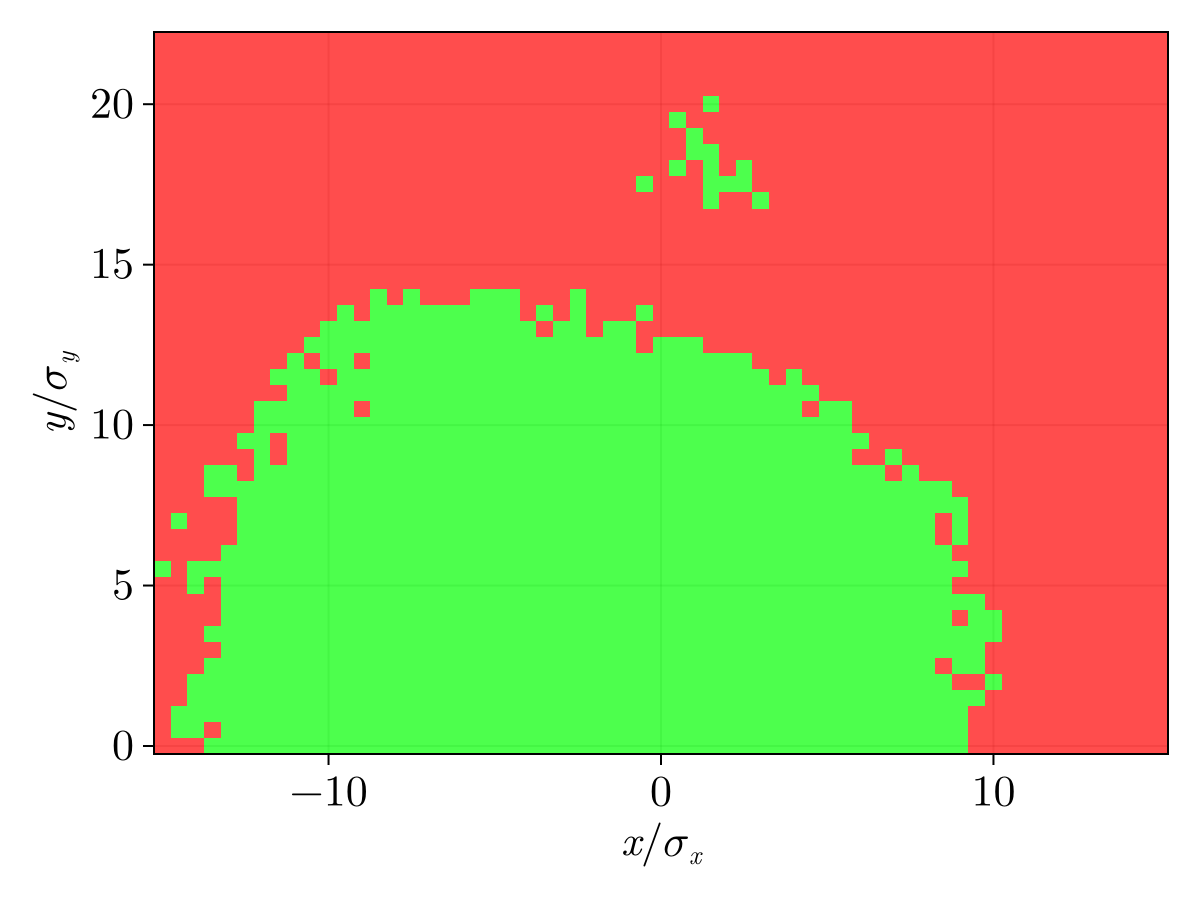

In [68]:
# let's plot a grid now as test before pushing final
# THIS IS 1 step per element FOURTH ORDER YOSHIDA
#x = b0.coords.v[:,1]
#y = b0
f2 = Figure(fontsize=22);#, size=(800,400));
ax = Axis(f2[1, 1], xlabel=L"x/\sigma_x", ylabel=L"y/\sigma_y")
#contour!(v0[:,1]./sig_x, v0[:,3]./sig_y, b0.coords.state; color=:black, linewidth=4)
heatmap!(v0[:,1]./sig_x, v0[:,3]./sig_y, b0.coords.state; colormap=[RGBAf(0,1,0,0.7),RGBAf(1,0,0,0.7)])
display(f2);

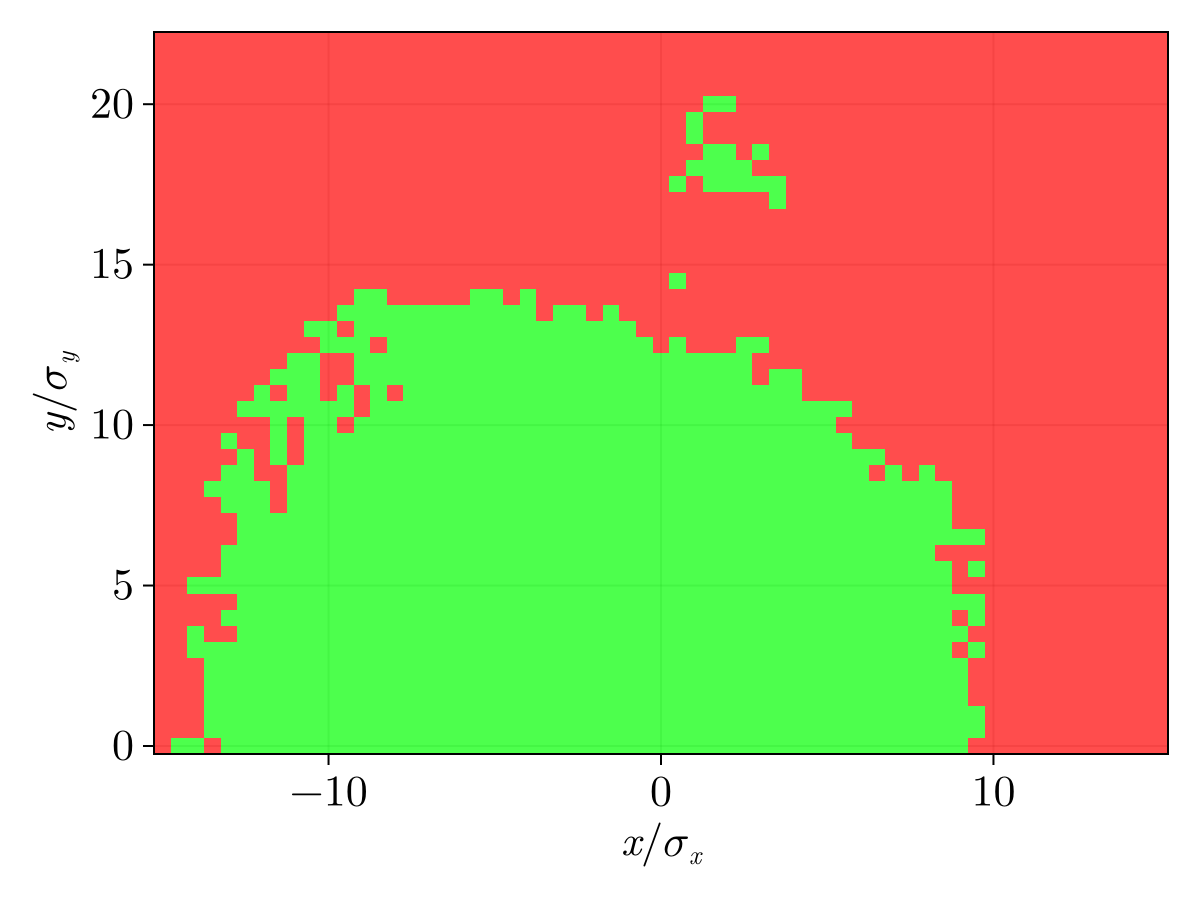

In [72]:
# let's plot a grid now as test before pushing final
# THIS IS 3 steps per element FOURTH ORDER YOSHIDA
#x = b0.coords.v[:,1]
#y = b0
f2 = Figure(fontsize=22);#, size=(800,400));
ax = Axis(f2[1, 1], xlabel=L"x/\sigma_x", ylabel=L"y/\sigma_y")
#contour!(v0[:,1]./sig_x, v0[:,3]./sig_y, b0.coords.state; color=:black, linewidth=4)
heatmap!(v0[:,1]./sig_x, v0[:,3]./sig_y, b0.coords.state; colormap=[RGBAf(0,1,0,0.7),RGBAf(1,0,0,0.7)])
display(f2);

In [58]:
2.5*100/60

4.166666666666667

In [12]:
Float32.([1.,2.,3.])

3-element Vector{Float32}:
 1.0
 2.0
 3.0

In [74]:
N_particles

2745

In [75]:
SciBmad.BeamTracking.REGISTER_SIZE

static(32)